# Introduction

Proposed by Vaswani et al. in their seminal 2017 paper *"Attention Is All You Need"*, the transformer architecture has become the dominant model for a wide range of tasks. It has largely replaced LSTMs in language processing and played a pivotal role in the revolution of large language models (LLMs). In fact, the "T" in ChatGPT stands for transformer.

Transformers are not only useful for language, they have also proven highly effective in other modalities, including images. In this project, we will explore the building blocks of the Vision Transformer, focusing on the **self-attention mechanism** at its core. In the second part, we will experiment with a pre-trained model to gain a better understanding of its inner workings.

**Please do not forget to comment on the sections with answer the question**. 
You can write your answers in the same cell as the question.

This notebook is self-contained, but you can refer to the resources below for more detailed information:

1. **Original Transformer Paper:** [Attention Is All You Need](https://arxiv.org/pdf/1706.03762)
2. **Vision Transformer Paper:** [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929)
3. **Transformer Tutorial:** [Basics of Transformer](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)
4. **Stanford CS224n Notes (personal favorite):** [Self-Attention and Transformers (2023 Draft)](https://web.stanford.edu/class/cs224n/readings/cs224n-self-attention-transformers-2023_draft.pdf)


# Part 1: Components of the Transformer

In this section, we will review the components of the transformer architecture. Some functions are provided, while you are expected to implement the remaining ones. Please answer the questions along the way.


### Tokenization (Patchifying an Image)

In the transformer architecture, the input is partitioned into basic units called tokens. At the heart of the self-attention mechanism (which is the core of the transformer) is the ability to capture relationships between any two tokens in the input, enabling the discovery of **long-range dependencies**. For text, tokens typically represent consecutive characters. For simplicity, we can assume that each word in a sentence is a token.

In this case, self-attention examines the relationship between each word and every other word in the sentence (including itself) to generate a new representation for that word based on the similarity scores.

In the image domain, defining tokens is simpler. Given an image of size $H \times W$, we first divide it into square patches of size $P \times P$. Each patch is then flattened to obtain a vector, which becomes our token. The image is then represented by $N$ tokens, where

$$
N = \frac{H \times W}{P^2}
$$

Each token vector consists of $P^2 \times C$ elements, with $C$ being the number of color channels in the image.

As the first step in our implementation, let's take a look at the patchification of an image.

**Note**:
In practice, a class (CLS) token is appended to the input for classification tasks. We omit it for simplicity in this part, we will see more of this in the second part of the assignment.

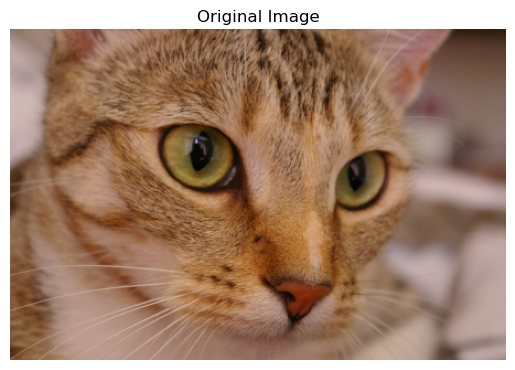

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

# Load Chelsea image
image = data.chelsea()
cropped_image = image[:300, :450, :]

plt.imshow(cropped_image)
plt.title("Original Image")
plt.axis("off")
plt.show()

Above we have the image that will be processed by the transformer.
The patches obtained by calling **patchify_image** function are given below with their numbers.

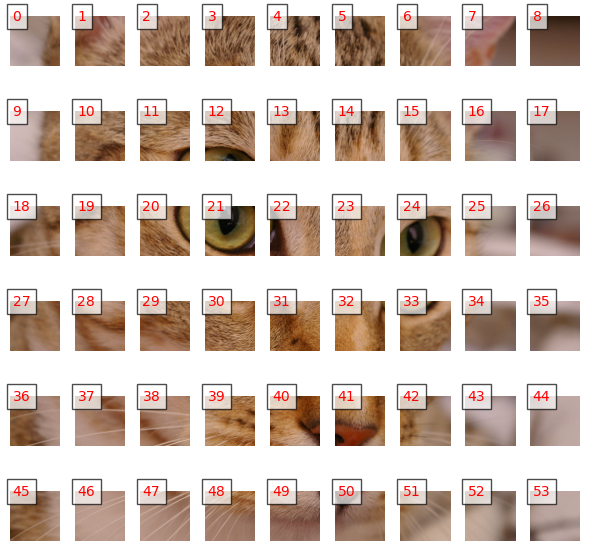

In [31]:
def patchify_image(x_in, patch_size):
    """
    Patch Tokenization function
    # Input
        x_in (np.ndarray) : Image tensor of shape (H,W,C) 
        patch_size (int): Patch Size
    # Output
        x_out (np.ndarray): Return a matrix of size (N,C*P^2)
    """
    
    H,W,C = x_in.shape
    N_h = H // patch_size
    N_w = W // patch_size
    x_out = np.zeros([N_h*N_w,C*patch_size**2])
    
    for i in range(N_h):
        for j in range(N_w):
            x_out[(i*N_w) + j,:] = (x_in[i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size,:]).flatten()
    
    return x_out


def display_patches(tokens, patch_size, image_shape):
    H, W, _ = image_shape
    n_h = H // patch_size
    n_w = W // patch_size
    
    # n_h rows, n_w columns
    fig, axes = plt.subplots(n_h, n_w, figsize=(6, 6))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        y = tokens[i, :].reshape((patch_size, patch_size, 3))
        y = y.astype(np.uint8) # need to convert to int for display
        ax.imshow(y, vmin=0, vmax=255)
        ax.axis("off")
        # print the token number
        ax.text(2, 4, str(i), fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.7)) 

    plt.tight_layout()
    plt.show()
    
# Patchify
patch_size = 50
tokens = patchify_image(cropped_image, patch_size)

# Display
display_patches(tokens, patch_size, cropped_image.shape)

### Self-Attention in Transformers

In the previous part, we obtained the tokens (image patches) that the transformer model takes as input. Transformer models operate by representing the information from each token based on its relation to every other token in the input. For instance, while processing the top-left patch (token 0), the model uses its relation with every other patch to obtain an updated representation for that patch. The same idea applies to text, where every token (word) in a sentence is processed by the transformer, taking into account the relationships between any pair of tokens. This mechanism is called **self-attention** and it enables the transformer to capture **long-term dependencies**.

The self-attention layer is the most important component of the transformer architecture. Now, let’s take a closer look at how it works.

Self-attention represents every element in the input (tokens initially, and feature vectors for the deeper layers in the network) as a weighted sum of the representations of all other elements in the sequence. This is achieved by computing three vectors for every element:

1. **Key**: What a token offers to other tokens. (of length $d_k$)
2. **Query**: What each token looks for in the other tokens. (of length $d_k$)
3. **Value**: The representation of each token, which we sum over using the computed weights to get the final representations. (of length $d_v$)

For the $i$-th element in the input sequence, the similarity score (weight) is computed by taking the dot product of its query vector $q_i$ with the key vectors of every token in the sequence (including itself):

$$
\alpha_i = q_i \cdot K^T
$$

where $K$ is the matrix containing the key vectors for all tokens in its rows.

These scores are then scaled by the factor $ \frac{1}{\sqrt{d_k}} $ to keep the variance of the dot product in check:

$$
\alpha'_i = \frac{q_i \cdot K^T}{\sqrt{d_k}}
$$

Finally, a softmax is applied to $ \alpha'_i $ to obtain the attention weights:

$$
w_{ij} = \frac{\exp(\alpha'_{ij})}{\sum_{k} \exp(\alpha'_{ik})}
$$

The output representation $o_i$ for the $i$-th element is computed as the weighted sum of the value vectors $v_j$:

$$
o_i = \sum_{j} w_{ij} \, v_j
$$

A self-attention layer takes an input $X$ of dimension $(T, D)$, where $T$ is the sequence length and $D$ is the input dimension. It then uses three linear projection matrices $W_K$, $W_Q$, and $W_V$ to obtain the keys, queries, and values, respectively:

$$
\begin{aligned}
K &= X W_K, \quad \text{dimensions } (T \times d_k) \\
Q &= X W_Q, \quad \text{dimensions } (T \times d_k) \\
V &= X W_V, \quad \text{dimensions } (T \times d_v)
\end{aligned}
$$

The dot products between the queries and keys can grow large in magnitude when $d_k$ is high. Dividing by $\sqrt{d_k}$ prevents these values from becoming too large, which helps stabilize gradients during training and ensures that the softmax function does not enter regions with extremely small gradients. (Recall that softmax input taking too low/high values leads to small gradients)

The output $o_i$ from the attention layer becomes the input to the next layer, which allows to build higher-level representations in the deeper layers.

Now complete the following **dot_product_SA** function to implement the self-attention mechanism.

In [32]:
def dot_product_SA(x,W_k,W_q,W_v):
    """
    Self-attention function
    # Input
        x   (np.ndarray) : Input matrix of shape (T,D) 
        W_k (np.ndarray) : Linear projector for key (D,d_k) 
        W_q (np.ndarray) : Linear projector for query (D,d_k) 
        W_v (np.ndarray) : Linear projector for value (D,d_v)  
    # Output
        x_out (np.ndarray): Return a matrix of size (T,d_v)
    """
    
    # -----------------------------
    #        YOUR CODE HERE
    # -----------------------------
    # 1. Compute keys, queries, values
    K = x @ W_k  # (T, d_k)
    Q = x @ W_q  # (T, d_k)
    V = x @ W_v  # (T, d_v)

    # 2. Compute raw attention scores
    scores = Q @ K.T  # (T, T)

    # 3. Scale by sqrt(d_k)
    d_k = W_k.shape[1]
    scores = scores / np.sqrt(d_k)

    # 4. Softmax over each row
    #    (each token i attends to all tokens j)
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    attn_weights = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # (T, T)

    # 5. Weighted sum over values
    output = attn_weights @ V  # (T, d_v)
    # -----------------------------
    #        YOUR CODE HERE
    # -----------------------------
    
    return output

In [33]:
# Test the self-attention function
np.random.seed(42)

# Dimensions
T = 4
D = 6
d_k = 5
d_v = 2

# Create random input data
x = np.random.randn(T, D)  # (T, D)

# Generate weight matrices
W_k = np.random.randn(D, d_k)  # (D, d_k)
W_q = np.random.randn(D, d_k)  # (D, d_k)
W_v = np.random.randn(D, d_v)  # (D, d_v)

# Call SA function
output = dot_product_SA(x, W_k, W_q, W_v)

# Print the output
print("Self-Attention Output:")
print(output) # (T,d_v)


Self-Attention Output:
[[-0.49973861 -2.29958198]
 [-0.84494707  2.58606031]
 [-0.42453007  0.37405675]
 [-0.49994822 -2.30716273]]


If your implementation is correct you should see this array as the output:

[[-0.49973861 -2.29958198]  
 [-0.84494707  2.58606031]  
 [-0.42453007  0.37405675]  
 [-0.49994822 -2.30716273]]

# Answer the question! (Q1)

Assuming we can process a variable number of tokens as input, what are the benefits and downsides of using a smaller patch size (P) to patchify our input image ? Please name at least one advantage and disdvantage. 

### Answer:

Advantage:
- Smaller patch sizes can capture more fine-grained details of the image, as each patch covers a smaller region and captures more localalized features. Moreover, the model can process finer features, which may be beneficial for tasks that require more detail, such as detecting multiple smaller objects.

Disadvantage:
- Smaller patches increase the number of tokens in the input, leading to higher computational costs. This can increase both training and inference time, especially when dealing with large images. Besides, the model may need to handle more long-range dependencies, which increases computational complexity and could make it harder to capture global features.


### Position Encoding

The self-attention mechanism is simple yet powerful, and it played a crucial role in the emergence of transformer-based LLMs like ChatGPT, which millions of students worldwide rely on to complete their homework every day.

However, the way we implemented the tokenization process and self-attention layer is not suitable for processing texts (or images) because **we do not have a notion of positional closeness** in the current implementation.

For example, consider the image patches we obtained earlier. If we apply our self-attention function to process them, we would get an output for each patch based solely on its relation to every other patch regardless of their original arrangement. <br>

In other words, the current mechanism does not distinguish between the original order of the patches and an arbitrary shuffling of them. Thus, the transformer network **cannot differentiate between the original image patches and the shuffled ones below**.



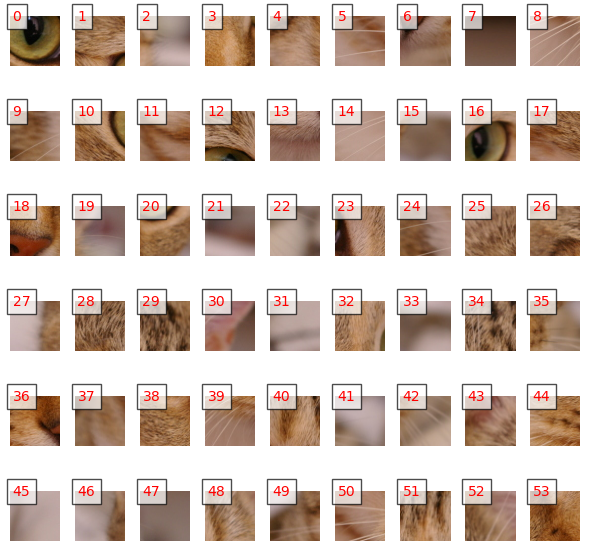

In [34]:
rng = np.random.default_rng()
arr = np.arange(54)
rng.shuffle(arr)

patch_size = 50
tokens = patchify_image(cropped_image, patch_size)

image = data.chelsea()
cropped_image = image[:300, :450, :]

display_patches(tokens[arr], patch_size, cropped_image.shape)

For both images and texts, it is crucial to incorporate positional information. The relationship between words (in text) or patches (in an image) depends not only on their content but also on their relative positions. Transformers achieve this by adding a **positional encoding** vector to each token in the input. The positional encoding is constructed using a sinusoidal function with varying frequencies across different hidden dimensions.

For each token at position $pos$ in the sequence and each dimension $i$ in the hidden dimensions, the positional encoding is defined as:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{D}}}\right)
$$

$$
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{D}}}\right)
$$

where:

- $pos$ is the position index in the sequence (from $0$ to $T-1$ for an input with $T$ tokens).
- $i$ is the dimension index (from $0$ to $D-1$).
- $D$ is the total embedding dimension.

The denominator term $10000^{\frac{2i}{D}}$ scales the frequencies of the sine and cosine functions, ensuring that **each hidden dimension has a different periodicity**.

Thus, the **positional encoding matrix** $PE$ has the same shape as the tokenized input matrix:

$$
PE \in \mathbb{R}^{T \times D}
$$

where $T$ is the sequence length and $D$ is the embedding dimension.

The final input to the transformer is the sum of the token embeddings and the positional encoding:

$$
X_{\text{position-encoded}} = X_{\text{tokenized}} + PE
$$

where:

- $X_{\text{tokenized}} \in \mathbb{R}^{T \times D}$ is the tokenized input matrix.
- $PE \in \mathbb{R}^{T \times D}$ is the positional encoding matrix.
- $X_{\text{position-encoded}}$ is the final input fed into the transformer network.

By incorporating positional encoding, transformers can now capture positional relationships between tokens, distinguishing between different word orders in sentences and spatial arrangements in images.

In [35]:
# Position embedding
def pos_embed(T,D):
    """
    Positional Encoding function
    # Input
         T: Sequence length
         D: Hidden dimension
    # Output
        x_out (np.ndarray): Return a matrix of size (T,D) with positional embeddings
    """
    
    pos_matrix = np.array([np.arange(T),]*D).transpose()
    
    denum_matrix = np.ones([T,D])*10000
    denum_idx_matrix = (np.array([np.repeat(np.arange(D//2),2),]*T)*2)/D
    denum_matrix = np.power(denum_matrix, denum_idx_matrix)
    pe_matrix = np.divide(pos_matrix,denum_matrix)
    
    phase_shift = np.array([0,np.pi/2])
    phase_shift = np.array([phase_shift,]*T)
    phase_shift = np.tile(phase_shift, (1, D//2))
    pe_matrix = pe_matrix + phase_shift
    
    return np.sin(pe_matrix)
    


Below we get a display of the position encoding matrix for an input of $1000$ tokens with hidden dimension $50$.

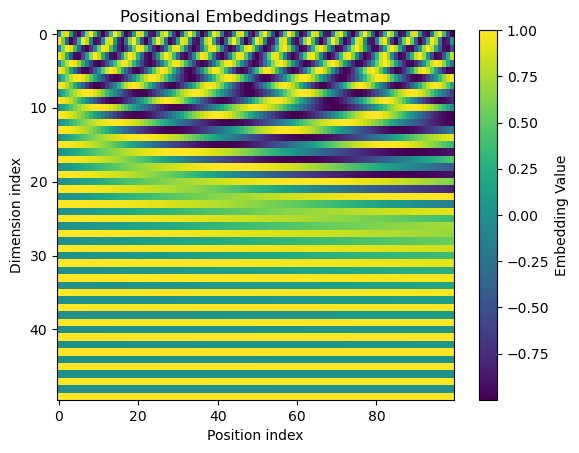

In [36]:
T,D = 100,50
    
pe = pos_embed(T,D)

plt.imshow(pe.T, aspect='auto', cmap='viridis')  # pe.T to get dimension on the y-axis
plt.colorbar(label="Embedding Value")
plt.title("Positional Embeddings Heatmap")
plt.xlabel("Position index")
plt.ylabel("Dimension index")
plt.show()

# Answer the question!  (Q2)

Can you comment on the difference between the sinusodial functions in different dimensions ? Do you see any pattern for consecutive dimensions or can we say anything about the change in frequency as dimension index increases ?

### Answer:

- Each pair of consecutive dimensions uses sine and cosine functions of the same base frequency: $\sin(\frac{pos}{10000^{\frac{2i}{D}}})$ and $\cos(\frac{pos}{10000^{\frac{2i}{D}}})$, respectively for given dimmension indices i, i+1.
The frequency decreases exponentially with respect to the dimmension index i. This enables the model to capture local and global positional information since each token will have a unique position and dimmension encoding. Note that as the dimmension index gets large enough, the encoding tends towards alternating 0's and 1's since the frequency $f = (10000^{\frac{2i}{D}})^{-1}$ goes exponentially to 0.



So, we  covered most of the components required to build a transformer network. Next, we refine some details to complete our implementation.

In practice, attention layers in transformers often use multiple self-attention *heads* concurrently. This is similar to how convolutional layers in CNNs use multiple kernels to extract various features from the input. By employing multiple self-attention heads, each attention head can learn to focus on different aspects of the input simultaneously.

This approach is called **Multi-Head Attention**. Suppose we have an input 
$$
X \in \mathbb{R}^{T \times D},
$$ 
where $T$ is the sequence length and $D$ is the input dimension.

Each attention head independently transforms the input into key, query, and value triplets using its own projection matrices:
$$ W_Q^i \in \mathbb{R}^{D \times d_k}, $$
$$ W_K^i \in \mathbb{R}^{D \times d_k}, $$
$$ W_V^i \in \mathbb{R}^{D \times d_v}. $$

For the $i$-th head, these projections are computed as:
$$
Q^i = X W_Q^i, \quad K^i = X W_K^i, \quad V^i = X W_V^i.
$$

Each head then computes its output $O^i \in \mathbb{R}^{T \times d_v}$ using the self-attention mechanism described earlier. Once all $h$ heads have computed their outputs, we concatenate them along the feature dimension to obtain:
$$
O = \text{concat}(O^1, O^2, \dots, O^h),
$$
so that
$$
O \in \mathbb{R}^{T \times (h \cdot d_v)}.
$$

Finally, this concatenated output is projected to the desired output dimension $d_{\text{out}}$ using a linear projection matrix 
$$
W_O \in \mathbb{R}^{(h \cdot d_v) \times d_{\text{out}}},
$$
resulting in the final output of the multi-head attention layer:
$$
\text{MultiHead}(X) = O W_O.
$$

Please complete the following **multi_head_attention** function given below by using **dot_product_SA** function you implemented earlier. **Be careful about the dimensions of the input elements, check the comments.** 

In [40]:
# Multi-head attention
def multi_head_attention(W_q,W_k,W_v,W_o,x):
    """
    Multi head attention
    h: head count
    T: sequence length
    D: hidden dimension (assumed to be equal for input and output to multi-head attention)
    d_k: dimension of key and query
    d_v: dimension of value
    # Input
         W_q: Tensor containing Wq matrices of shape (h,D,d_k)
         W_k: Tensor containing Wk matrices of shape (h,D,d_k)
         W_v: Tensor containing Wv matrices of shape (h,D,d_v)
         W_o: Output porjection matrix shape (h*d_v, D)
         x: Input shape (T,D)
    # Output
         x_out (np.ndarray): Return a matrix of size (T,D)
    """
    
        
    # -----------------------------
    #        YOUR CODE HERE
    # -----------------------------
    h = W_q.shape[0]  # number of heads
    head_outputs = []

    # 1. Loop over each attention head
    for i in range(h):
        # Apply single-head self-attention
        head_out = dot_product_SA(x, W_k[i], W_q[i], W_v[i])  # (T, d_v)
        head_outputs.append(head_out)

    # 2. Concatenate all heads along the feature dimension
    multi_head_concat = np.concatenate(head_outputs, axis=1)  # (T, h*d_v)

    # 3. Final projection to (T, D)
    x_out = multi_head_concat @ W_o  # (T, D)
    # -----------------------------
    #        YOUR CODE HERE
    # -----------------------------
    
    return x_out

d_k = 15
d_v = 10
D = 3
T = 2
h = 5

np.random.seed(42)

# Create random input data
x = np.random.randn(T, D)  # (T, D)

# Generate weight tensors
W_k = np.random.randn(h, D, d_k)  # (h, D, d_k)
W_q = np.random.randn(h, D, d_k)  # (h, D, d_k)
W_v = np.random.randn(h, D, d_v)  # (h, D, d_v)
W_o = np.random.randn(h*d_v,D)

# get the output
x_out = multi_head_attention(W_q,W_k,W_v,W_o,x)

print(x_out)


[[ -6.58072435 -10.05748565  -1.5506343 ]
 [ -4.79706338  -5.78697211  -6.05258561]]


If your implementation is correct you should see this array as the output:

[[ -6.58072435 -10.05748565  -1.5506343 ]  
 [ -4.79706338  -5.78697211  -6.05258561]]

We are almost done with our implementation of the transformer. Let's put everything together to implement a single-layer transformer as shown in the figure below:

<img src="transformer_encoder_only.png" alt="Transformer (Encoder) Layer" width="250">

In the figure, you see what is called a **transformer encoder** network. For simplicity, we will refer to the encoder layer as the transformer layer. The Vision Transformer is also built using encoder layers, so do not worry about the differences between encoder and decoder layers.

In the Vision Transformer, we start with the patchified image that already includes positional embeddings. Recall that the positional embedding is added to the tokenized input, so that:

$$
X_{\text{position-encoded}} = X_{\text{tokenized}} + PE.
$$

Next, $X_{\text{position-encoded}}$ is passed through the multi-head attention module to produce $X_{\text{attention}}$:

$$
X_{\text{attention}} = \text{MultiHead}(X_{\text{position-encoded}}).
$$

The *Add \& Norm* block then uses a residual connection to add the original input of the multi-head attention to its output, and the result is normalized. This normalization is performed by **Layer Normalization**, which is similar to batch normalization but computes the normalization statistics over the features for each element individually. Although layer normalization is crucial for stable learning in transformers, we omit it in our implementation for simplicity. You can check the original paper if you are interested in learning more about layer normalization: [https://arxiv.org/pdf/1607.06450](https://arxiv.org/pdf/1607.06450).

The output of the first *Add \& Norm* block is denoted as $X_1$. This output is then fed into a feed-forward layer, which is implemented as a two-layer MLP with a ReLU nonlinearity. The feed-forward network is expressed as follows:

$$
X_{\text{FF}} = \text{ReLU}(X_1 \cdot W_1 + b_1)\cdot W_2 + b_2.
$$

Finally, another *Add \& Norm* block is applied to combine $X_1$ and $X_{\text{FF}}$, giving the final output of the transformer layer.

A transformer network is obtained by concatenating multiple blocks like this. The $N$ in the figure represents $N$ transformer (encoder) layers, where the output of the first layer becomes the input to the second layer’s multi-head attention, and so on.


Now complete the implementation of the **transformer_layer** given below according to description given above. **Please check the comments inside the function for details.**

In [41]:
# Transformer layer (Ask them to implement this)
def transformer_layer(x,W_q,W_k,W_v,W_o,W_1,W_2,b_1,b_2):
    """
    Transformer (encoder) layer
    
    Takes a batch (B) of inputs (T,D) matrices, returns the output of transformer layer.
    Each input matrix passes through multi-head attention -> Add -> FF -> Add
    
    Use the function you implemented earlier for multi-head attention.
    
    Beware we do not use normalization, we have only addition for the Add & Norm layers.
    
    Hint: You can use a for loop to process batch.
    
    B: batch_size
    T: sequence length
    D: hidden dimension (assumed to be equal for input and output)
    
    h: head count
    d_k: dimension of key and query
    d_v: dimension of value
    
    # Input
         W_q: Tensor containing Wq matrices of shape (h,D,d_k)
         W_k: Tensor containing Wk matrices of shape (h,D,d_k)
         W_v: Tensor containing Wv matrices of shape (h,D,d_v)
         W_o: Output porjection matrix shape (h*d_v, D)
         W_1, W_2: Weight matrices in the feed-forward layer (D,D)
         b_1, b_2: Bias vectors in the feed-forward layer (D)
         x: Input shape (B,T,D)
    # Output
         x_out (np.ndarray): Return a tensor of shape (B,T,D)
    """
    
    # -----------------------------
    #        YOUR CODE HERE
    # -----------------------------
    B, T, D = x.shape
    x_out_list = []

    for b_idx in range(B):
        # 1) Multi-head attention
        mh_out = multi_head_attention(W_q, W_k, W_v, W_o, x[b_idx])  # (T,D)

        # 2) Add & (skip) Norm
        x_1 = x[b_idx] + mh_out  # (T,D)

        # 3) Feed-forward: ReLU(X_1 W_1 + b_1) W_2 + b_2
        ff_input = x_1 @ W_1 + b_1  # (T,D)
        ff_hidden = np.maximum(ff_input, 0)  # ReLU
        ff_out = ff_hidden @ W_2 + b_2      # (T,D)

        # 4) Add & (skip) Norm
        x_final = x_1 + ff_out
        x_out_list.append(x_final)

    # Stack back to shape (B,T,D)
    x_out = np.stack(x_out_list, axis=0)
    # -----------------------------
    #        YOUR CODE HERE
    # -----------------------------
        
    return x_out

In [42]:
B = 2 
T = 3
D = 2
h = 4
d_k = 10
d_v = 15

# Generate random input and parameters
np.random.seed(42)

x = np.random.randn(B,T,D)  # (B, T, D)

# Generate weight tensors
W_k = np.random.randn(h, D, d_k)  # (h, D, d_k)
W_q = np.random.randn(h, D, d_k)  # (h, D, d_k)
W_v = np.random.randn(h, D, d_v)  # (h, D, d_v)
W_o = np.random.randn(h*d_v,D)
W_1 = np.random.randn(D,D)
W_2 = np.random.randn(D,D)
b_1 = np.random.randn(D)
b_2 = np.random.randn(D)


# get the output
x_out = transformer_layer(x,W_q,W_k,W_v,W_o,W_1,W_2,b_1,b_2)

print(x_out[0])
print(x_out[1])



[[ 6.51401336  4.19475558]
 [11.2861679   9.07559194]
 [ 4.76125266  1.90389302]]
[[ 9.14781168  2.44186795]
 [10.60588289  2.81959273]
 [ 5.08703529  1.33589121]]


If your implementation is correct you should be getting the following two matrices:

[[ 6.51401336  4.19475558]  
 [11.2861679   9.07559194]  
 [ 4.76125266  1.90389302]]    
[[ 9.14781168  2.44186795]  
 [10.60588289  2.81959273]  
 [ 5.08703529  1.33589121]]

Now you know the fundamentals of transformer architecture and how it processes an image.  